In [2]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from math import log10, sqrt
import torchvision.transforms.functional as F
from einops import rearrange

# Ques 1
Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank $r$. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics. 

In [3]:
import os
if os.path.exists('fashion.jpg'):
    print('fashion.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/shutterstock_466589609.jpg -O fashion.jpg

--2024-09-15 17:55:40--  https://segment-anything.com/assets/gallery/shutterstock_466589609.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.229.91, 18.65.229.20, 18.65.229.55, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.229.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478925 (468K) [image/jpeg]
Saving to: ‘fashion.jpg’

fashion.jpg         100%[===================>] 467.70K  --.-KB/s    in 0.03s   

2024-09-15 17:55:41 (14.9 MB/s) - ‘fashion.jpg’ saved [478925/478925]



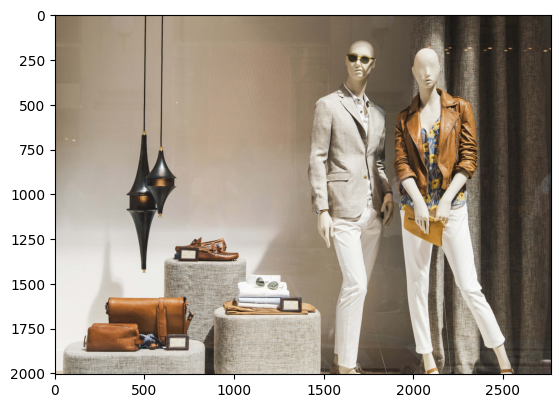

In [5]:
image_path = "fashion.jpg"
img = torchvision.io.read_image(image_path) # Reading original image
plt.imshow(rearrange(img, 'c h w -> h w c').numpy()) # Rearranging to imshow format(H W C)
plt.show()

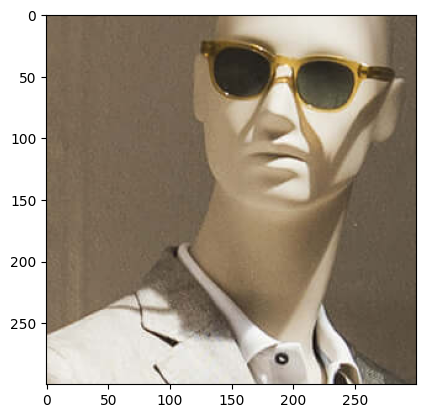

In [46]:
# Defining cropping parameters: top, left, height, width
top = 200  # Starting y-coordinate
left = 1500  # Starting x-coordinate
height = 300  # Height of the crop
width = 300  # Width of the crop

# Cropping the image
cropped_img = F.crop(img, top, left, height, width)

# Converting (C,H,W) to (H,W,C) which is the format required for plotting with matplotlib
cropped_img = rearrange(cropped_img, 'c h w -> h w c').numpy()

# Displaying the cropped image
plt.imshow(cropped_img)
plt.show()

In [7]:
def factorize(A, k, device=torch.device("cpu")):
    A = A.to(device)

    # Random normaly initializing W(N x r) and H(r x M)
    # where N is no. of samples, r is rank and M is no. of features
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

    # Adam Optimizer with learning rate 0.01
    optimizer = optim.Adam([W, H], lr=0.01)

    # Training the model
    for i in range(2000):
        # Computing the loss (Frobenius norm of the difference)
        reconstruction = torch.mm(W, H)  # Reconstructed matrix
        loss = torch.norm(reconstruction - A)  # Frobenius norm of (W * H - A)

        # Zeroing the gradients
        optimizer.zero_grad()

        # Backpropagating the loss
        loss.backward()

        # Updating the parameters
        optimizer.step()

        # Printing progress every 200 epochs
        if (i + 1) % 200 == 0:
            print(f"Epoch [{i+1}/2000], Loss: {loss.item():.4f}")

    return W, H, loss

In [33]:
def factorize_rgb(image, k, device=torch.device("cpu")):

    # Splitting the image into R, G, and B channels
    R = torch.tensor(image[:, :, 0], dtype=torch.float32)
    G = torch.tensor(image[:, :, 1], dtype=torch.float32)
    B = torch.tensor(image[:, :, 2], dtype=torch.float32)

    # Factorizing each channel seperately
    print("For R Channel: ")
    W_r, H_r, _ = factorize(R, k, device)
    print("\nFor G Channel: ")
    W_g, H_g, _ = factorize(G, k, device)
    print("\nFor B Channel: ")
    W_b, H_b, _ = factorize(B, k, device)

    # Reconstructing each channel
    reconstructed_R = torch.mm(W_r, H_r).cpu().detach().numpy()
    reconstructed_G = torch.mm(W_g, H_g).cpu().detach().numpy()
    reconstructed_B = torch.mm(W_b, H_b).cpu().detach().numpy()

    # Stacking the channels to form the reconstructed RGB image
    reconstructed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=2)

    return reconstructed_image

Peak Signal-Noise Ratio $(\text{PSNR})$ formula is given by: $\text{PSNR} = 20 \times \log_{10} \left(\frac{\text{MAX Pixel Intensity}}{\text{RMSE}}\right)$

In [10]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(original, reconstructed):
    return np.sqrt(mean_squared_error(original.flatten(), reconstructed.flatten()))

def calculate_psnr(original, reconstructed):
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())
    if mse == 0:  # MSE is zero means no noise
        return 100
    max_pixel = 255.0  # Assuming 8-bit image
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [12]:
def display(original_image,reconstructed_image):
  # Displaying original and reconstructed images for comparison
  plt.figure(figsize=(10, 5))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.title("Original Image")
  plt.imshow(original_image.astype(np.uint8))

  # Reconstructed Image
  plt.subplot(1, 2, 2)
  plt.title(f"Reconstructed Image (Rank = {rank})")
  plt.imshow(np.clip(reconstructed_image, 0, 255).astype(np.uint8))  # Clipping to valid pixel range

  plt.show()

In [47]:
# Lists to store the results
ranks = []
rmse_values = []
psnr_values = []

# Looping through the ranks and calculating RMSE and PSNR
for i in range(50, 251, 50):
    rank = i
    print(f"Rank = {rank} : ")
    reconstructed_img = factorize_rgb(cropped_img, rank)
    rmse = calculate_rmse(cropped_img, reconstructed_img)
    psnr = calculate_psnr(cropped_img, reconstructed_img)

    # Appending values to the lists
    ranks.append(rank)
    rmse_values.append(rmse)
    psnr_values.append(psnr)

    # Printing the result
    print(f"RMSE: {rmse:.4f}")
    print(f"PSNR: {psnr:.2f} dB\n")

Rank = 50 : 
For R Channel: 
Epoch [200/2000], Loss: 11018.5361
Epoch [400/2000], Loss: 7447.5713
Epoch [600/2000], Loss: 4305.5200
Epoch [800/2000], Loss: 2479.6799
Epoch [1000/2000], Loss: 1635.4777
Epoch [1200/2000], Loss: 1300.1965
Epoch [1400/2000], Loss: 1210.9642
Epoch [1600/2000], Loss: 1188.7728
Epoch [1800/2000], Loss: 1180.5331
Epoch [2000/2000], Loss: 1175.6438

For G Channel: 
Epoch [200/2000], Loss: 11324.8369
Epoch [400/2000], Loss: 7641.7153
Epoch [600/2000], Loss: 4162.1514
Epoch [800/2000], Loss: 2327.0842
Epoch [1000/2000], Loss: 1577.7600
Epoch [1200/2000], Loss: 1294.0645
Epoch [1400/2000], Loss: 1216.7068
Epoch [1600/2000], Loss: 1193.3711
Epoch [1800/2000], Loss: 1184.6681
Epoch [2000/2000], Loss: 1179.6637

For B Channel: 
Epoch [200/2000], Loss: 10555.5381
Epoch [400/2000], Loss: 6599.8652
Epoch [600/2000], Loss: 3383.1233
Epoch [800/2000], Loss: 1907.2603
Epoch [1000/2000], Loss: 1352.1907
Epoch [1200/2000], Loss: 1228.5630
Epoch [1400/2000], Loss: 1195.2035
E

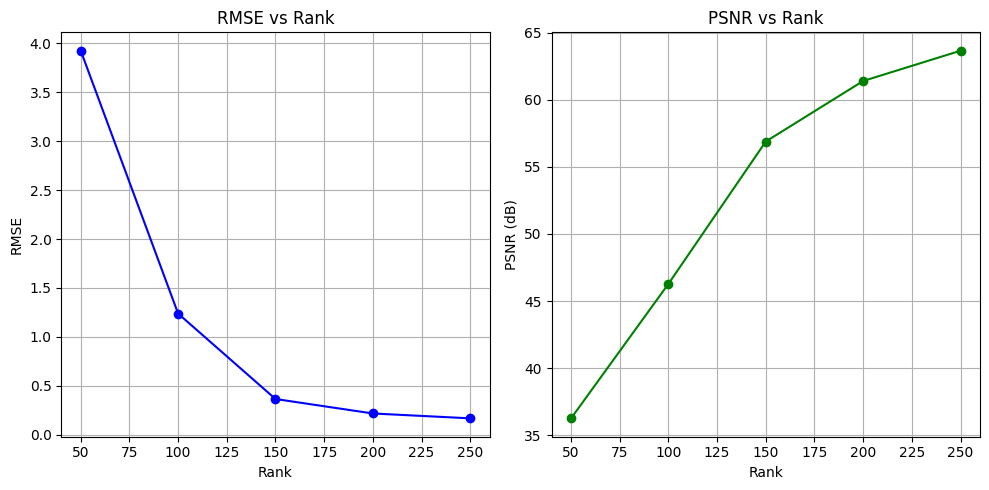

In [52]:
# Plotting the variation of RMSE and PSNR
plt.figure(figsize=(10,5))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(ranks, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE vs Rank')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.grid(True)

# PSNR plot
plt.subplot(1, 2, 2)
plt.plot(ranks, psnr_values, marker='o', linestyle='-', color='g')
plt.title('PSNR vs Rank')
plt.xlabel('Rank')
plt.ylabel('PSNR (dB)')
plt.grid(True)

# Showing the plots
plt.tight_layout()
plt.show()

* Based on the graph, RMSE (Root Mean Squared Error) decreases as the rank increases, while PSNR (Peak Signal to Noise Ratio) improves with higher rank values. Since the dimensions $(N)$ and $(M)$ are both $300$, the rank $(r)$ should remain relatively small compared to $300$. Beyond a rank of $150$, the model starts to overfit the data. Therefore, selecting a rank of $150$ offers a better balance for more accurate predictions.

In [55]:
rank = 150
reconstructed_img = factorize_rgb(cropped_img, rank)

For R Channel: 
Epoch [200/2000], Loss: 8043.8735
Epoch [400/2000], Loss: 2271.3105
Epoch [600/2000], Loss: 665.5790
Epoch [800/2000], Loss: 298.4659
Epoch [1000/2000], Loss: 190.0361
Epoch [1200/2000], Loss: 153.9033
Epoch [1400/2000], Loss: 135.5690
Epoch [1600/2000], Loss: 124.6240
Epoch [1800/2000], Loss: 117.4931
Epoch [2000/2000], Loss: 112.4808

For G Channel: 
Epoch [200/2000], Loss: 7747.2461
Epoch [400/2000], Loss: 2030.2196
Epoch [600/2000], Loss: 560.5759
Epoch [800/2000], Loss: 257.8567
Epoch [1000/2000], Loss: 179.0514
Epoch [1200/2000], Loss: 143.9173
Epoch [1400/2000], Loss: 126.3463
Epoch [1600/2000], Loss: 116.4464
Epoch [1800/2000], Loss: 110.3316
Epoch [2000/2000], Loss: 106.2814

For B Channel: 
Epoch [200/2000], Loss: 7013.6099
Epoch [400/2000], Loss: 1608.2113
Epoch [600/2000], Loss: 415.6653
Epoch [800/2000], Loss: 207.0616
Epoch [1000/2000], Loss: 149.8959
Epoch [1200/2000], Loss: 129.3714
Epoch [1400/2000], Loss: 117.9034
Epoch [1600/2000], Loss: 111.2794
Epoc

In [56]:
rmse = calculate_rmse(cropped_img, reconstructed_img)
psnr = calculate_psnr(cropped_img, reconstructed_img)
# Print the result
print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.2f} dB\n")

RMSE: 0.3588
PSNR: 57.03 dB



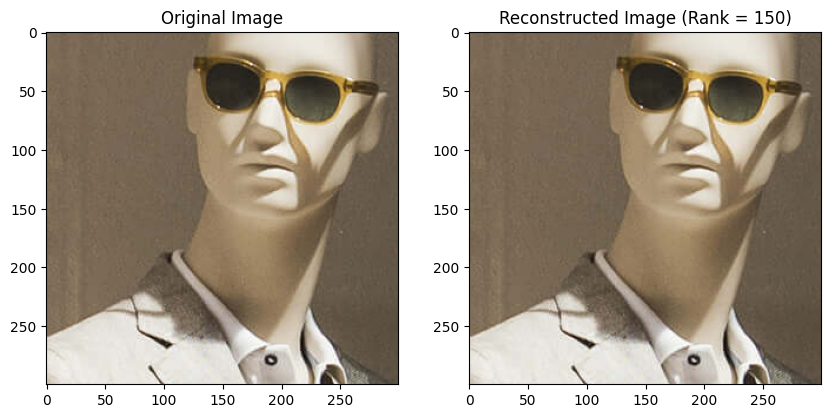

In [57]:
display(cropped_img,reconstructed_img)